Subdivide the images of Covid + pneumonia into:
Train - validation - test sets.

Train PCA on the train set (keep 90% of info), generate component images.

Script of June 26th - July 3rd

See: module "dim reduction", intro lesson 1.

June 27th:load the images using OpenCV.

V4: appeler le chargement des images depuis une fonction.

_Résultat_: dans ce script, la fonction génère le DataFrame avec un ordre de lignes différent,
cela ne change pas le dessin, mais change le train-test split. Le score de la prédiction baisse de 0.87 à 0.68 (plus haut, que la random, amais en-dessous de la prédiction constante de la classe majoritaire == 0.74)!

Les performaces du modèle SVM varient entre 0.87, 0.68, 0.81 suite à des modifications aléatoires.

V5: charger les images par une  fonction spécifique.
_Résultat:_ le temps pour charger les images passe à 10 secondes.

In [1]:
# imports
import os

import matplotlib.pyplot as plt
import time
import pandas as pd

# import cv2

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import classification_report

from load_images_PCA1_v5 import load_list_paths


# Load data into a large DF (append target var as the last column). 

Concatenate DataFrames using a single function call.


In [2]:
condition_2plot_COV = "COVID"
condition_2plot_Pneumo = "Viral Pneumonia"
lst_dirs = [os.path.join("../data", condition_2plot_Pneumo, "images"), os.path.join("../data", condition_2plot_COV, "images")]
var_target = 'COVID'

start = time.time()
df = load_list_paths(lst_dirs, var_target)
done = time.time()

elapsed = done - start
print(f'time = {elapsed:.2f} sec \n\n')
# 10 sec

print(df.shape)   # (4961, 89402) 
print(df.info())

df.head()

# The result should be identical to the previous one.

time = 9.41 sec 


(4961, 89402)
<class 'pandas.core.frame.DataFrame'>
Index: 4961 entries, 0 to 4960
Columns: 89402 entries, 0 to COVID
dtypes: uint8(89402)
memory usage: 423.0 MB
None


,0,1,2,3,4,5,6,7,8,9,...,89392,89393,89394,89395,89396,89397,89398,89399,89400,COVID
0,1,1,2,3,3,3,3,4,11,17,...,0,0,0,0,0,0,0,0,0,0
1,72,74,76,75,86,114,142,152,150,143,...,0,0,0,0,0,0,0,0,0,0
2,27,30,32,33,35,37,41,46,47,49,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,2,4,4,5,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,2,17,23,...,0,0,0,0,0,0,0,0,0,0


# train-validation-test split

In [3]:
# separate features, target.
data = df.drop(var_target, axis=1)
target = df[var_target]

print(data.info())  # (4961, 89401)
print('------')
print(type(target))  # Series
print(target.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 4961 entries, 0 to 4960
Columns: 89401 entries, 0 to 89400
dtypes: uint8(89401)
memory usage: 423.0 MB
None
------
<class 'pandas.core.series.Series'>
(4961,)


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data,
    target,
    test_size=0.1,
    random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=1234)

print(X_train.shape)  # (3571, 89401)
print(X_val.shape)     # (893, 89401)
print(X_test.shape)    # (497, 89401)

(3571, 89401)
(893, 89401)
(497, 89401)


# train PCA on train set
Output: number of components for achieving 90% of info.

In [5]:
# (p)
pca90 = PCA(n_components=0.9)

start = time.time()
X_train_pca = pca90.fit_transform(X_train)
done = time.time()

elapsed = done - start
print(f'Time for training PCA = {elapsed:.2f} sec \n\n')

print(X_train_pca.shape)  # (3571, 50)

X_val_pca = pca90.transform(X_val)
print(X_val_pca.shape)  # (893, 50)

# About 3 mins.

Time for training PCA = 163.11 sec 


(3571, 50)
(893, 50)


PCA a réduit le nombre de colonnes de près de 90000 à 50.

# scatterplot of components 1, 2 colored according to their class

In [6]:
# (q)
def plt_scatter_dims12(data, colors):
    """
    Affiche les 2 premiéres colonnes d'une matrice.

    Args:
        data (_type_): _description_
        colors (_type_): _description_

    Returns:
        _type_: _description_
    """
    return plt.scatter(data[:, 0], data[:, 1], c=colors)

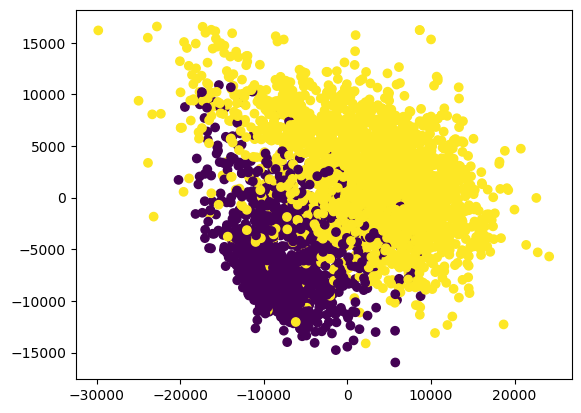

In [7]:
plt_scatter_dims12(X_train_pca, y_train)

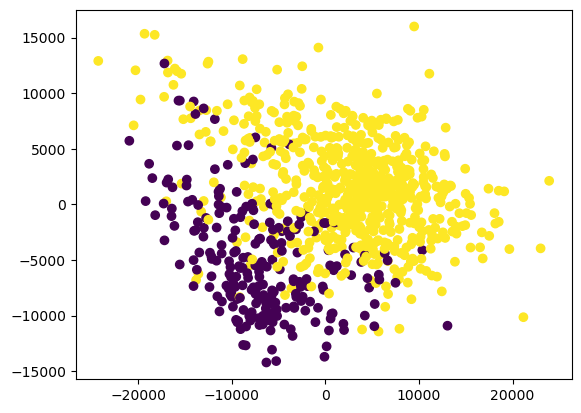

In [8]:
plt_scatter_dims12(X_val_pca, y_val)

Avec seulement 2 variables, nous voyons une séparation entre les classes!

2 affichages suivants peuvent être ajoutés: Cercle de corrélations, eigenfaces.

Entrainer un classifieur sur le train, appliquer aux données de validation.



In [9]:
clf = SVC(C = 1, kernel = 'linear', max_iter=100, random_state=1)

start = time.time()
clf.fit(X_train_pca, y_train)
done = time.time()

elapsed = done - start
print(f'Training time on reduced data = {elapsed:.2f} sec \n\n')

print("Score on reduced data :", clf.score(X_val_pca, y_val))  # 0.87, 0.68, ...


Training time on reduced data = 0.02 sec 


Score on reduced data : 0.6797312430011199


/home/alex/anaconda3/envs/DSTest_proj_env04/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [10]:
y_pred_val = clf.predict(X_val_pca)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.41      0.51      0.45       232
           1       0.81      0.74      0.77       661

    accuracy                           0.68       893
   macro avg       0.61      0.63      0.61       893
weighted avg       0.71      0.68      0.69       893



In [11]:
# confusion mmatrix
pd.crosstab(y_val, y_pred_val)

col_0,0,1
COVID,,
0,119,113
1,173,488


This classifier treats well the bigger class. A following version should assign coefficients during training.